In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/math-students/student-mat.csv


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import shap
import warnings

warnings.filterwarnings("ignore")

2024-03-30 00:52:09.326925: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 00:52:09.327005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 00:52:09.328574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/math-students/student-mat.csv")

df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [4]:
column_names = df.columns
column_names

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [5]:
# one hot encode binary colummns
for column in df.columns:
    if column in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'schoolsup', 'famsup', 
                  'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
        
        cat_0, cat_1 = list(df[column].value_counts().index) # get the two categories
        # apply(lambda ...) converts to int64 dtype
        df[column] = df[column].apply(lambda x: 1 if x == cat_0 else 0).astype(np.float16)

In [7]:
# one hot encode non binary categorical columns
onehot_df = pd.get_dummies(data=df, columns=["age", "Mjob", "Fjob", "reason", "guardian"])

In [8]:
# pandas dummies one hot encoded columns are boolean true/false which don't work with tensorflow
for column in onehot_df.columns:
    if onehot_df[column].dtype == "bool":
        onehot_df[column] = onehot_df[column].apply(lambda x: 1 if x == True else 0).astype(np.float16)

In [9]:
target = onehot_df["G3"]
onehot_df.drop(columns=["G3"], inplace=True)

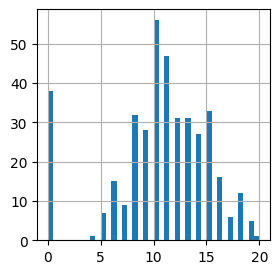

In [10]:
plt.figure(figsize=(3, 3))
df["G3"].hist(bins=40)
plt.show()

In [11]:
# turn real target to binary
def create_binary_target(row):
    if row < 10:
        value = 0
    else:
        value = 1
    return value

binary_target = target.apply(create_binary_target)
binary_target

0      0
1      0
2      1
3      1
4      1
      ..
390    0
391    1
392    0
393    1
394    0
Name: G3, Length: 395, dtype: int64

In [12]:
binary_target.value_counts()

G3
1    265
0    130
Name: count, dtype: int64

In [13]:
input_layer = tf.keras.layers.Input(shape=(52,))
dense_1 = tf.keras.layers.Dense(units=20, activation="relu")
dense_2 = tf.keras.layers.Dense(units=30, activation="relu")
_output_layer = tf.keras.layers.Dense(units=1, activation="sigmoid")

x = dense_1(input_layer)
x = dense_2(x)
output_layer = _output_layer(x)

model = tf.keras.Model(inputs=[input_layer], outputs=[output_layer])

# tf.keras.utils.plot_model(model)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 52)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │         1,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,721 (6.72 KB)

 Trainable params: 1,721 (6.72 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

model_history = model.fit(x=onehot_df, y=binary_target, 
                          shuffle=True, epochs=20, verbose=0)

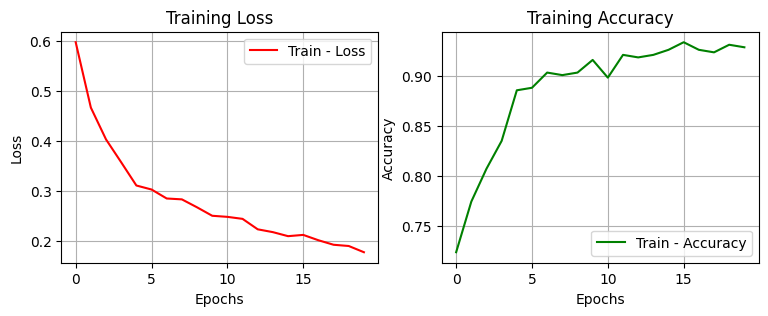

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 3))
ax[0].plot(model_history.history["loss"], label="Train - Loss", color="red")
ax[0].legend(loc="upper right")
ax[0].set_title("Training Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].grid(True)

ax[1].plot(model_history.history["accuracy"], label="Train - Accuracy", color="green")
ax[1].legend(loc="lower right")
ax[1].set_title("Training Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].grid(True)
plt.show()

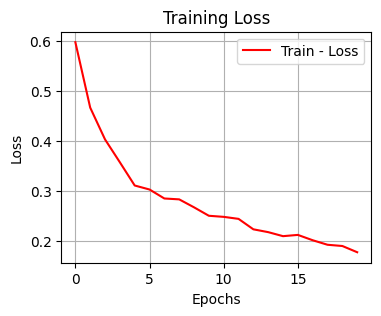

In [16]:
plt.figure(figsize=(4, 3))
plt.plot(model_history.history["loss"], label="Train - Loss", color="red")
plt.legend(loc="upper right")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
input_1 = onehot_df.loc[0].to_numpy().astype(np.float16)
input_1 = np.expand_dims(input_1, axis=0)
input_1.shape

(1, 52)

In [18]:
model.predict(input_1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


array([[0.02982634]], dtype=float32)

# Get model predictions

In [19]:
raw_predictions = model.predict(onehot_df.to_numpy().astype(np.float16))
rounded_predictions = np.round(raw_predictions)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [20]:
raw_predictions_df = pd.DataFrame(np.squeeze(raw_predictions), columns=["raw_predictions"])
raw_predictions_df.head()

,raw_predictions
0,0.029826
1,0.048591
2,0.321678
3,0.981398
4,0.739741


# Evaluation Scores

In [217]:
type(raw_predictions)

numpy.ndarray

In [229]:
from sklearn.metrics import precision_recall_curve, roc_curve

def graph_pr_roc_curves(binary_target: pd.Series, 
                        raw_predictions: np.ndarray) -> None:
    
    """
    inputs: 
        binary_target: Pandas Series of shape (num_examples, )
        raw_predictions: Numpy array of shape (num_examples, 1)
        
    This function plots precision-recall and ROC curves.
    
    outputs: 
        None
    """
    
    raw_predictions_df = pd.DataFrame(np.squeeze(raw_predictions), columns=["raw_predictions"])
    
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
    
    # PR curve
    precisions, recalls, pr_thresholds = precision_recall_curve(binary_target, raw_predictions_df.raw_predictions)
    axs[0].plot(recalls, precisions, linewidth=2)
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title("Precision/Recall Curve")
    axs[0].grid(True)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(binary_target, raw_predictions_df.raw_predictions)
    axs[1].plot(fpr, tpr, linewidth=2)
    axs[1].set_xlabel("False Positive Rate")
    axs[1].set_ylabel("True Positive Rate")
    axs[1].set_title("ROC Curve")
    axs[1].grid(True)
    
    # precision recall tradeoff curves
    axs[2].plot(pr_thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    axs[2].plot(pr_thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    axs[2].set_title("Precision-Recall Tradeoff Curve")
    axs[2].set_xlabel("Decision Thresholds")
    axs[2].set_ylabel("Precision or Recall")
    axs[2].grid(True)
    axs[2].legend(loc="lower left")

    plt.show()

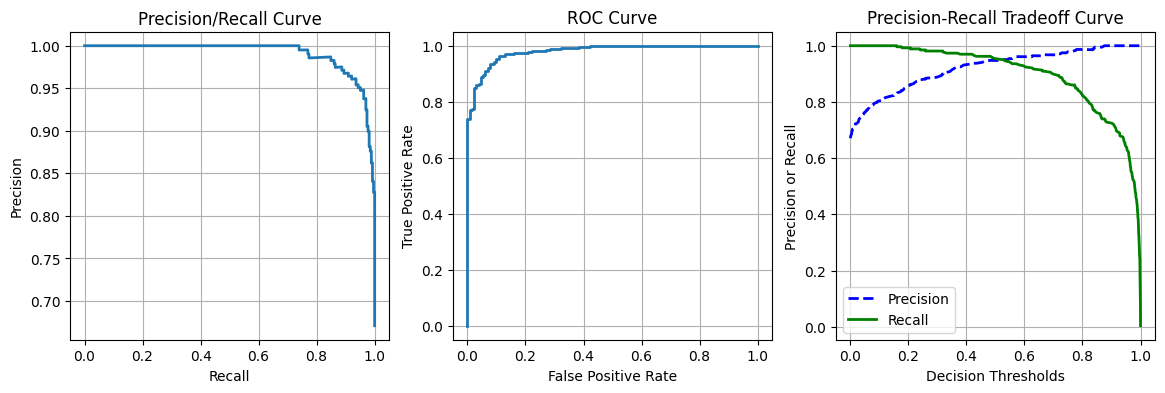

In [25]:
graph_pr_roc_curves(binary_target, raw_predictions)

In [230]:
def make_binary_decision(predictions_dataframe: pd.DataFrame, 
                         decision_threshold: float) -> pd.DataFrame:
    
    """
    inputs: 
        predictions_dataframe: Pandas DataFrame of shape (num_examples, 1) containing raw prediction probabilities
        raw_predictions: floating point number
        
    This function adds a column to the predictions_dataframe that turns raw probabilities into a binary decision
    based on the decision_threshold.
    
    outputs: 
        predictions_dataframe with a new column
    """
    
    predictions_dataframe["decision"] = predictions_dataframe["raw_predictions"].apply(lambda x: 1 if x > decision_threshold else 0)
    return predictions_dataframe

In [234]:
def calculate_eval_metrics(binary_target: pd.Series,
                           decision_rounded_prediction: np.ndarray) -> pd.DataFrame:

    """
    inputs: 
        binary_target: Pandas Series of shape (num_examples, )
        raw_predictions: Numpy array of shape (num_examples, 1)
        
    This function calculates accuracy, precision, recall, and f-1 score and puts all the evaluation
    metrics in a Pandas dataframe.
    
    outputs: 
        evaluation_scores: Pandas DataFrame of shape (4, 2)
    """
    
    accuracy = accuracy_score(binary_target, decision_rounded_prediction)
    precision = precision_score(binary_target, decision_rounded_prediction)
    recall = recall_score(binary_target, decision_rounded_prediction)
    _f1_score = f1_score(binary_target, decision_rounded_prediction)
    
    evaluation_scores = pd.DataFrame([accuracy, precision, recall, _f1_score], 
                                     index=["Accuracy", "Precision", "Recall", "F1-Score"], columns=["score"])
    
    return evaluation_scores

In [239]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def graph_evaluations(binary_target: pd.Series, 
                      raw_predictions_df: pd.DataFrame, 
                      decision_threshold: float = 0.5) -> None:
    
    """
    inputs: 
        binary_target: Pandas Series of shape (num_examples, )
        raw_predictions_df: Pandas DataFrame of shape (num_examples, 1)
        
    This function graphs evaluations scores accuracy, precision, recall, and f-1 score
    along with the confusion matrix and percentage error matrices.
    
    outputs: 
        None
    """
    
    raw_predictions_df = make_binary_decision(raw_predictions_df, decision_threshold)
    
    evaluation_scores = calculate_eval_metrics(binary_target, raw_predictions_df["decision"])
    
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8.5))
    
    plt.rc("font", size=9)
    axs[0][0].bar(x=evaluation_scores.index, height=evaluation_scores.score, color="green", alpha=0.7, 
               width=0.5, edgecolor="black", linewidth=2.5)
    axs[0][0].set_title("Evaluation Scores at {} Decision Threshold".format(decision_threshold))
    axs[0][0].grid(True)
    
    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(binary_target, raw_predictions_df["decision"], ax=axs[0][1])
    axs[0][1].set_title("Confusion Matrix at {} Decision Threshold".format(decision_threshold))
    
    # confusion matrix normalized by row
    ConfusionMatrixDisplay.from_predictions(binary_target, raw_predictions_df["decision"], ax=axs[1][0], 
                                            normalize="pred", values_format=".0%")
    axs[1][0].set_title("Column Normalized at {} Decision Threshold".format(decision_threshold))

    # confusion matrix normalized by row
    ConfusionMatrixDisplay.from_predictions(binary_target, raw_predictions_df["decision"], ax=axs[1][1], 
                                            normalize="true", values_format=".0%")
    axs[1][1].set_title("Row Normalized at {} Decision Threshold".format(decision_threshold))
    
    plt.show()

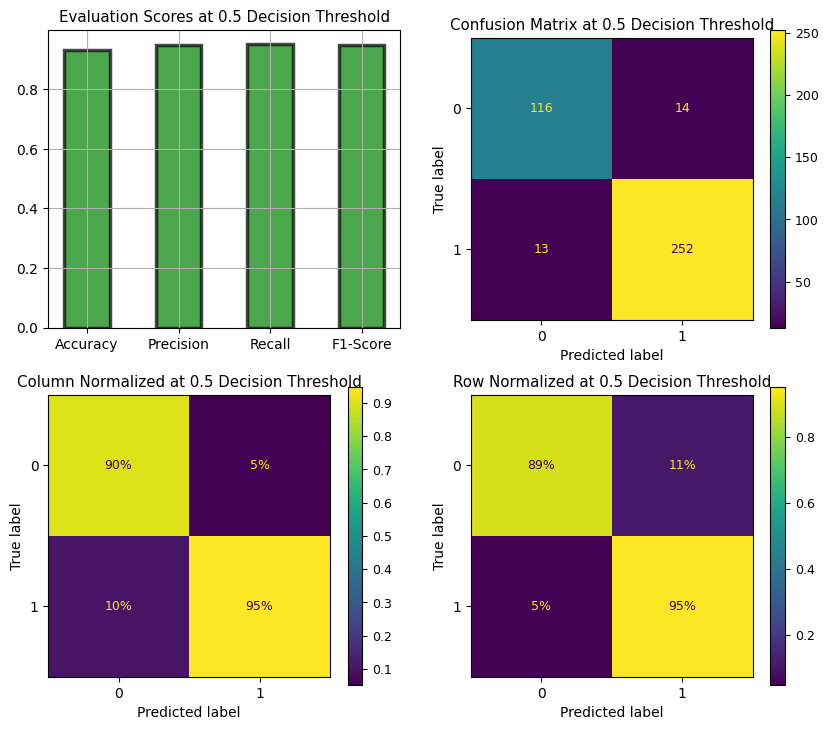

In [29]:
graph_evaluations(binary_target, raw_predictions_df, decision_threshold=0.5)

# Minimize total costs

### Let's assume that a false negative is 10 times more expensive than a false positive, also assume a false positive and true positive have the same cost, while a true negative has no expense

$$ totalCost = 10 * falseNegative + 1 * falsePositive + 1 * truePositive + 0 * trueNegative $$

### We want to find the decision threshold to classify a positive or negative example that minimizes the total cost

In [247]:
from sklearn.metrics import confusion_matrix

def calculate_cost(binary_target: pd.Series,
                   raw_predictions_df: pd.DataFrame,
                   prediction_costs: dict, 
                   decision_threshold: float = 0.5) -> float:
    
    """
    inputs: 
        binary_target: Pandas Series of shape (num_examples, )
        raw_predictions_df: Pandas DataFrame of shape (num_examples, 1)
        prediction_costs: Python dictionary containing the costs of true positives, true negatives, etc.
        
    This function calculates the total cost that would be incurred under the given decision_threshold
    by calculcating the confusion matrix and using it to find the total cost of each type of prediction.
    
    outputs: 
        total_cost: float 
    """    
    
    raw_predictions_df = make_binary_decision(raw_predictions_df, decision_threshold)
    
    evaluation_scores = calculate_eval_metrics(binary_target, raw_predictions_df["decision"])
    
    _confusion_matrix = confusion_matrix(binary_target, raw_predictions_df["decision"])
    
    true_negative_cost = _confusion_matrix[0, 0] * prediction_costs["true_negative"]
    true_positive_cost = _confusion_matrix[1, 1] * prediction_costs["true_positive"]
    false_positive_cost = _confusion_matrix[0, 1] * prediction_costs["false_positive"]
    false_negative_cost = _confusion_matrix[1, 0] * prediction_costs["false_negative"]
    
    total_cost = true_negative_cost + true_positive_cost + false_positive_cost + false_negative_cost
    
    return total_cost

In [252]:
def minimize_prediction_cost(binary_target: pd.Series,
                             raw_predictions_df: pd.DataFrame, 
                             prediction_costs: dict) -> (float, float):
    
    """
    inputs: 
        binary_target: Pandas Series of shape (num_examples, )
        raw_predictions_df: Pandas DataFrame of shape (num_examples, 1)
        prediction_costs: Python dictionary containing the costs of true positives, true negatives, etc.
        
    This function loops throught lots of decisions threholds, calculates the total cost that would be 
    incurred under each decision threshold and finds the minimum cost and the decision threshold which 
    incurs that cost and plots a graph of the cost for each decision threshold
    
    outputs: 
        (total_cost, decision_threshold_min_cost): float, float
    """   
    
    decision_thresholds = np.linspace(0, 1, 101)
    
    minimum_cost = np.inf
    all_costs = []
    decision_threshold_min_cost = None
    
    for decision_threshold in decision_thresholds:
        cost = calculate_cost(binary_target, raw_predictions_df, prediction_costs, decision_threshold)
        all_costs.append(cost)
        if cost < minimum_cost:
            minimum_cost = cost
            decision_threshold_min_cost = decision_threshold
            
    plt.figure(figsize=(4, 3))
    plt.plot(decision_thresholds, all_costs, linewidth=2, color="red", alpha=0.7)
    plt.xlabel("Decision Thresholds")
    plt.ylabel("Cost")
    plt.title("Decision Threshold Cost Curve")
    plt.grid(True)
    plt.show()
    
    return minimum_cost, decision_threshold_min_cost

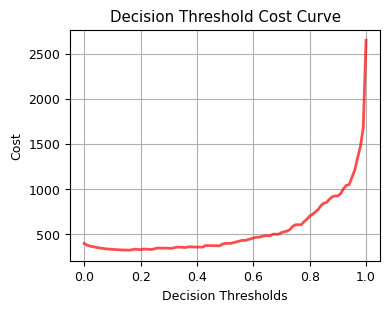

minimum cost: 320
decision threshold at minimum cost: 0.16


In [253]:
prediction_costs = { "true_negative": 0, "true_positive": 1, "false_positive": 1, "false_negative": 10 }

minimum_cost, final_decision_threshold = minimize_prediction_cost(binary_target, raw_predictions_df, prediction_costs)

print("minimum cost:", minimum_cost)
print("decision threshold at minimum cost:", final_decision_threshold)

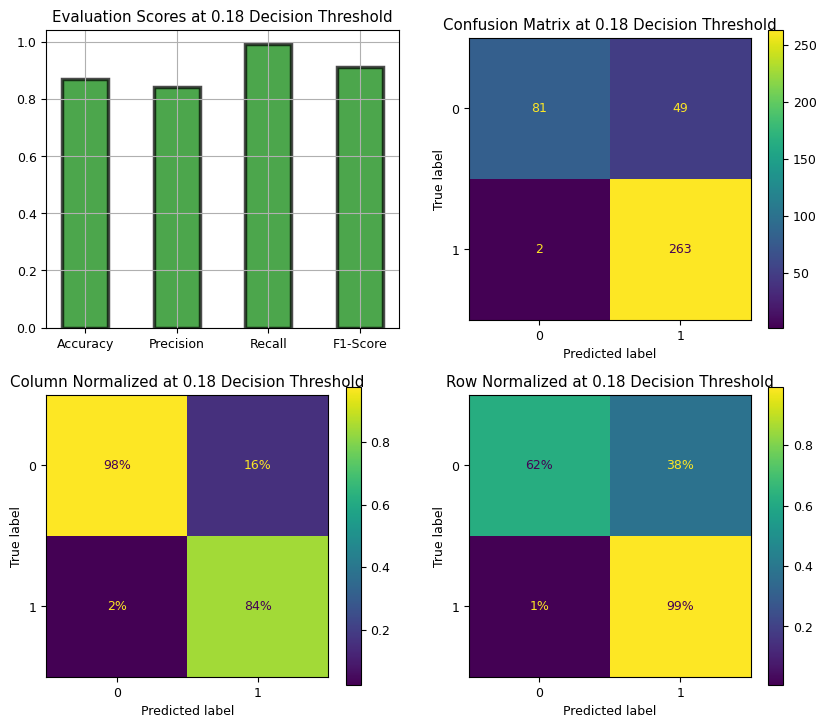

In [33]:
graph_evaluations(binary_target, raw_predictions_df, decision_threshold=0.18)

# Calibration

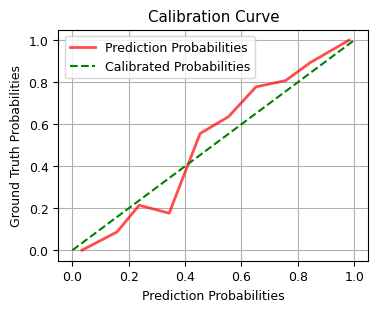

In [34]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(binary_target, raw_predictions, n_bins=10)

plt.figure(figsize=(4, 3))
plt.plot(prob_pred, prob_true, linewidth=2, color="red", alpha=0.7, label="Prediction Probabilities")
plt.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), "g--", color="green", label="Calibrated Probabilities")
plt.xlabel("Prediction Probabilities")
plt.ylabel("Ground Truth Probabilities")
plt.title("Calibration Curve")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

# Evaluation by losses on data points

In [35]:
# model.evaluate(pd.DataFrame(x1).transpose(), pd.Series(y1), batch_size=1)

model.evaluate(onehot_df[:1], binary_target[:1], batch_size=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 1.0000 - loss: 0.0303


[0.03028019517660141, 1.0]

In [255]:
def training_examples_by_losses(input_data: pd.DataFrame, 
                                binary_target: pd.Series, 
                                model: tf.keras.Model) -> (list, list):
    
    """
    inputs: 
        input_data: Pandas DataFrame of shape (num_examples, num_features)
        binary_target: Pandas Series of shape (num_examples, 1)
        model: a trained Tensorflow model
        
    This function takes the model loss on each data example in the input_data and appends it to a list.
    This list along with another list of loss indices is jointly sorted so we can list training examples
    on which the model has the most error.
    
    outputs: 
        (sorted_losses, sorted_indices): list, list
    """   
    
    losses = []
    num_examples = input_data.shape[0]
    
    for i in range(num_examples):
        x_i = input_data[i:i+1]
        y_i = binary_target[i:i+1]
        
        example_eval = model.evaluate(x_i, y_i, batch_size=1, verbose=0)
        losses.append(np.round(example_eval[0], 3))

    indexes = np.arange(0, onehot_df.shape[0])

    sorted_losses, sorted_indices = zip(*sorted(zip(losses, indexes), reverse=True))
        
    return sorted_losses, sorted_indices

In [265]:
def get_worst_k_examples(losses: list, 
                         indices: list, 
                         k: int = 10) -> pd.DataFrame:
    
    """
    inputs: 
        losses: list of shape (num_examples)
        indices: list of shape (num_examples)
        k: integer
        
    This function takes the sorted model losses list on each data example and the indices list 
    indicating where the index of the example is in the original dataframe.  Then we pick out the
    k training examples with the largest model loss and assemble the info in a dataframe. 
    
    outputs: 
        example_loss_df: pd.DataFrame of shape (k, 2)
    """   
    
    example_loss_df = pd.DataFrame([losses[:k], indices[:k]]).transpose() \
                    .rename(columns={ 0: "model_loss", 1: "training_example_index" }) 

    example_loss_df["training_example_index"] = example_loss_df["training_example_index"].astype(np.int32)

    return example_loss_df

In [258]:
%%timeit

sorted_losses, sorted_indices = training_examples_by_losses(onehot_df, binary_target, model)

26.7 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [266]:
example_loss_df = get_worst_k_examples(sorted_losses, sorted_indices, k=5)
example_loss_df

,model_loss,training_example_index
0,2.020,68
1,1.832,62
2,1.826,78
3,1.809,253
4,1.735,157


In [267]:
idx = example_loss_df["training_example_index"][0]
pd.set_option('display.max_columns', None)
pd.DataFrame(df.loc[idx]).transpose()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
68,1.0,1.0,15,0.0,0.0,1.0,2,2,health,services,reputation,mother,2,2,0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,4,1,3,1,3,4,2,8,9,8


# Model fairness

In [268]:
def baseline_vs_subset_evaluation(baseline_metrics: pd.DataFrame, 
                                  subset_metrics: pd.DataFrame, 
                                  subset_name: str, 
                                  color: str = "blue") -> None:
    
    """
    inputs:
        baseline_metrics: pd.DataFrame of shape (4, 1) with indices accuracy, precision, recall, f1-score 
        subset_metrics: pd.DataFrame of shape (4, 1) with indices accuracy, precision, recall, f1-score
        subset_name: str
        color: str
        
    This function plots the baseline model evaluation metrics against metrics obtained by
    evaluating model performance on various subsets or modifications of the origial dataset.
    
    outputs:
        None
    """
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
#     plt.rc("font", size=8)

    # baseline metrics
    axs[0].bar(x=baseline_metrics.index, height=baseline_metrics.score, color="green", alpha=0.5, 
                width=0.5, edgecolor="black", linewidth=2.5)
    axs[0].set_title("Baseline Evaluation Metrics")
    axs[0].set_ylabel("Percentage")
    axs[0].grid(True)
    
    # subset dataset metrics
    axs[1].bar(x=subset_metrics.index, height=subset_metrics.score, color=color, alpha=0.7, 
                width=0.5, edgecolor="black", linewidth=2.5)
    axs[1].set_ylabel("Perentage")
    axs[1].set_title(subset_name)
    axs[1].grid(True)

    plt.show()

In [269]:
original_pred_df = make_binary_decision(raw_predictions_df, decision_threshold=0.5)
baseline_eval_metrics = calculate_eval_metrics(binary_target, original_pred_df.decision)
baseline_eval_metrics

,score
Accuracy,0.931646
Precision,0.947368
Recall,0.950943
F1-Score,0.949153


In [270]:
# males = 0, or females = 1

# all data points belong to females
all_female_df = onehot_df.copy(deep=True)
all_female_df["sex"] = 1

all_female_raw_predictions = model.predict(all_female_df.to_numpy().astype(np.float16))

all_female_raw_predictions_df = pd.DataFrame(np.squeeze(all_female_raw_predictions), columns=["raw_predictions"])

all_female_pred_df = make_binary_decision(all_female_raw_predictions_df, decision_threshold=0.5)

all_female_eval_metrics = calculate_eval_metrics(binary_target, all_female_pred_df.decision)

all_female_eval_metrics

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,score
Accuracy,0.929114
Precision,0.954023
Recall,0.939623
F1-Score,0.946768


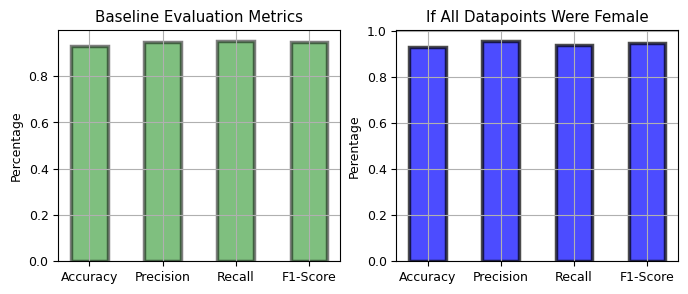

In [271]:
baseline_vs_subset_evaluation(baseline_eval_metrics, all_female_eval_metrics, "If All Datapoints Were Female")

In [52]:
# males = 0, or females = 1

# all data points belong to males
all_male_df = onehot_df.copy(deep=True)
all_male_df["sex"] = 0

all_male_raw_predictions = model.predict(all_male_df.to_numpy().astype(np.float16))

all_male_raw_predictions_df = pd.DataFrame(np.squeeze(all_male_raw_predictions), columns=["raw_predictions"])

all_male_pred_df = make_binary_decision(all_male_raw_predictions_df, decision_threshold=0.5)

all_male_eval_metrics = calculate_eval_metrics(binary_target, all_female_pred_df.decision)

all_male_eval_metrics

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,score
Accuracy,0.929114
Precision,0.954023
Recall,0.939623
F1-Score,0.946768


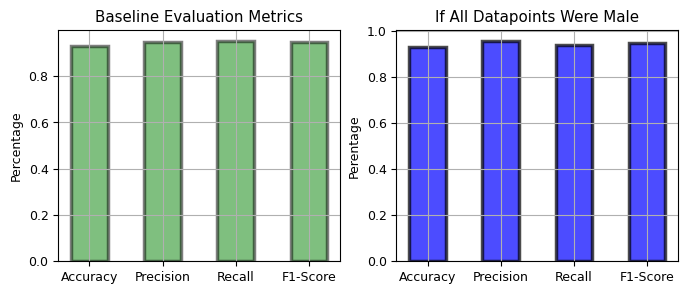

In [53]:
baseline_vs_subset_evaluation(baseline_eval_metrics, all_male_eval_metrics, "If All Datapoints Were Male")

# Data Slice Tests

In [54]:
female_only_rows = onehot_df[onehot_df["sex"] == 1]

female_only_target = target[female_only_rows.index]

female_only_binary_target = female_only_target.apply(create_binary_target)

In [55]:
female_only_df = onehot_df.copy(deep=True)

female_only_df = female_only_df[female_only_df["sex"] == 1]

female_only_raw_predictions = model.predict(female_only_df.to_numpy().astype(np.float16))

female_only_raw_predictions_df = pd.DataFrame(np.squeeze(female_only_raw_predictions), columns=["raw_predictions"])

female_only_pred_df = make_binary_decision(female_only_raw_predictions_df, decision_threshold=0.5)

female_only_eval_metrics = calculate_eval_metrics(female_only_binary_target, female_only_pred_df.decision)

female_only_eval_metrics

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,score
Accuracy,0.923077
Precision,0.946565
Recall,0.932331
F1-Score,0.939394


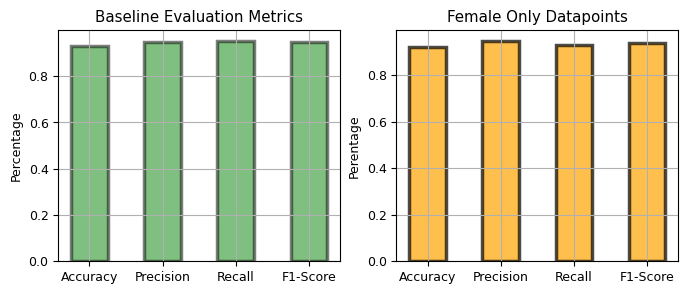

In [56]:
baseline_vs_subset_evaluation(baseline_eval_metrics, female_only_eval_metrics, "Female Only Datapoints", color="orange")

In [57]:
male_only_rows = onehot_df[onehot_df["sex"] == 0]

male_only_target = target[male_only_rows.index]

male_only_binary_target = male_only_target.apply(create_binary_target)

In [58]:
male_only_df = onehot_df.copy(deep=True)

male_only_df = male_only_df[male_only_df["sex"] == 0]

male_only_raw_predictions = model.predict(male_only_df.to_numpy().astype(np.float16))

male_only_raw_predictions_df = pd.DataFrame(np.squeeze(male_only_raw_predictions), columns=["raw_predictions"])

male_only_pred_df = make_binary_decision(male_only_raw_predictions_df, decision_threshold=0.5)

male_only_eval_metrics = calculate_eval_metrics(male_only_binary_target, male_only_pred_df.decision)

male_only_eval_metrics

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


,score
Accuracy,0.941176
Precision,0.948148
Recall,0.969697
F1-Score,0.958801


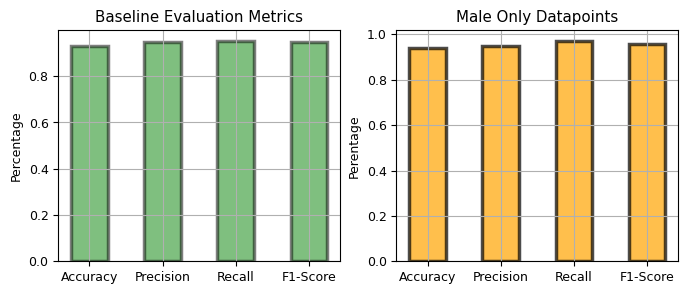

In [59]:
baseline_vs_subset_evaluation(baseline_eval_metrics, male_only_eval_metrics, "Male Only Datapoints", color="orange")

# males have much higher recall than females and overall but lower precision 

# Directional tests

In [60]:
max_studytime_df = onehot_df.copy(deep=True)

max_studytime_df["studytime"] = 4

max_studytime_raw_predictions = model.predict(max_studytime_df.to_numpy().astype(np.float16))

max_studytime_raw_predictions_df = pd.DataFrame(np.squeeze(max_studytime_raw_predictions), columns=["raw_predictions"])

max_studytime_pred_df = make_binary_decision(max_studytime_raw_predictions_df, decision_threshold=0.5)

max_studytime_eval_metrics = calculate_eval_metrics(binary_target, max_studytime_pred_df.decision)

max_studytime_eval_metrics

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


,score
Accuracy,0.913924
Precision,0.967611
Recall,0.901887
F1-Score,0.933594


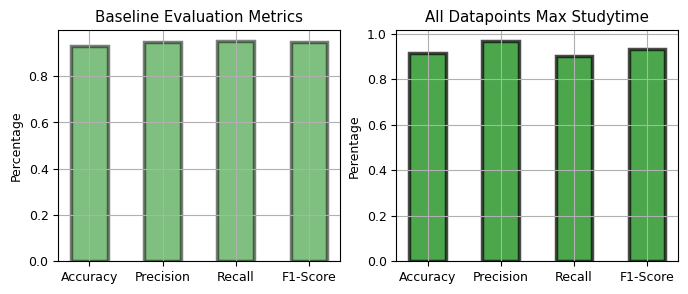

In [61]:
baseline_vs_subset_evaluation(baseline_eval_metrics, max_studytime_eval_metrics, "All Datapoints Max Studytime", color="green")

# surprisingly, accuracy, recall, f-1 score significantly drop while precision goes very high 
# suggesting there are some weaknesses in the model

# Feature attribution and model explanation using SHAP

In [104]:
shap.plots.initjs()

In [121]:
def f(x):
    return model.predict(x)

In [ ]:
explainer = shap.KernelExplainer(f, onehot_df)
shap_values = explainer.shap_values(onehot_df, nsamples=100)

In [211]:
shap.force_plot(explainer.expected_value, shap_values[0], onehot_df)

In [209]:
(onehot_df.columns[26], onehot_df.columns[25], onehot_df.columns[20], onehot_df.columns[5], onehot_df.columns[1], onehot_df.columns[50])

('G2', 'G1', 'goout', 'Medu', 'sex', 'guardian_mother')

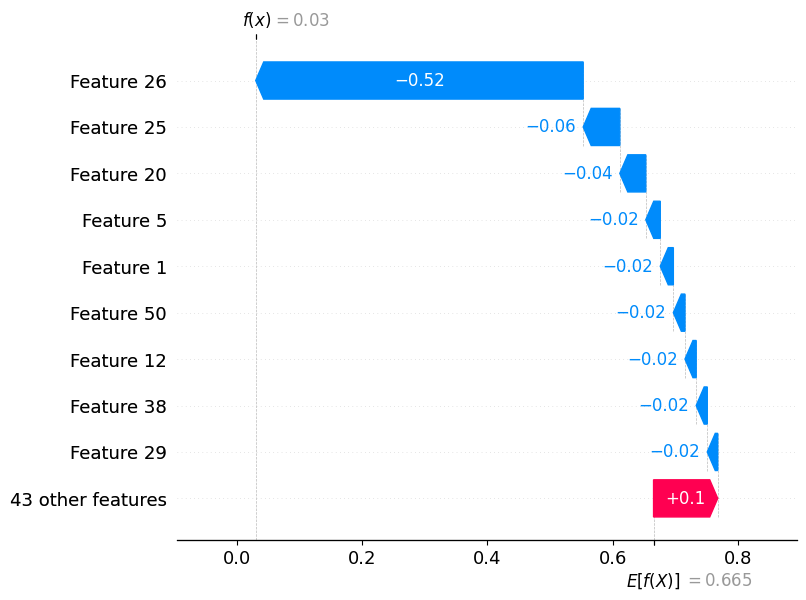

In [208]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0])

In [173]:
shap_values50 = explainer.shap_values(onehot_df[:30], nsamples=100)

shap.force_plot(explainer.expected_value, shap_values50[0], onehot_df[:50])

shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values50[0][0])

In [1]:
!jupyter nbconvert --to html "C:\Users\Arslan\Desktop\ml-notebooks\evaluating-a-model.ipynb

[NbConvertApp] Converting notebook C:\Users\Arslan\Desktop\ml-notebooks\evaluating-a-model.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 15 image(s).
[NbConvertApp] Writing 2374786 bytes to C:\Users\Arslan\Desktop\ml-notebooks\evaluating-a-model.html
